# Install required modules

In [1]:
# MIT License with GitHub Attribution
# Copyright (c) 2024 oomti (https://github.com/oomti)
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# Attribution Clause: Any use of the Software must be accompanied by visible and
# appropriate credit to the original author, oomti, including a link
# to the GitHub profile (https://github.comoomti). This credit must
# appear in all copies of the Software, substantial portions of the Software,
# and in any documentation or other materials provided with the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

!pip install langgraph
!pip install langchain
!pip install langchain-openai
!pip install pandas
!pip install langchain_core
!pip install langchain_experimental
!pip install pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 266.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: msgpack
    Found e

# Get OpenAI API Token

In [1]:
import os
import getpass

print("Enter your OpenAI API Key")
os.environ["OPENAI_API_KEY"] = getpass.getpass()

Enter your OpenAI API Key


KeyboardInterrupt: Interrupted by user

# Get DataSet

In [3]:
!wget https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv -O titanic.csv

--2024-10-10 12:40:00--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.03s   

2024-10-10 12:40:01 (1.30 MB/s) - ‘titanic.csv’ saved [44225/44225]



# Import Libraries

In [4]:
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState, Graph
from langchain_experimental.tools.python.tool import PythonREPLTool
from pydantic import BaseModel
import pandas as pd
import traceback


# Initialize LLM Model

In [7]:
#Initialise LLM Model

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)


# Define the system state

In [8]:

class State(TypedDict):
    # messages have the type "list".
    # The add_messages function appends messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]
    code: str
    data: str
    source: str


# Define the functions(nodes) affecting the state of the system

In [19]:
import re

def get_dataframe_head(state:State, file_name : str = "titanic.csv"):
   df = pd.read_csv(file_name)
   return {"data": json.dumps(df.head(10).to_dict())}

def planning_agent(state:State, llm:ChatOpenAI = llm):
  agent_instruction = SystemMessage(content = """
Based on the sample data and the incoming request,
Create a plan to write an efficient python code.
You need to create a detailed step by step instruction, for which part of the code should do what.
Once a pattern has been designed, the instructions will be passed ove to a coding agent.
Make the high level decisions. You have access to very basic python libraries(pandas)

Your responsibility is also to review the results of bad code and create an improved pattern if the code didn't get the right results.

""")

  response = llm.invoke([
      agent_instruction
      ]+state["messages"])
  return {"messages": [response]}

def coding_agent(state:State,llm:ChatOpenAI = llm):
  agent_instruction = SystemMessage(content = """
Based on the instructions and feedback - you need to write a working code.
You whole output is a code section(written in python, you have baseic libraries and pandas available)
Make sure you don't write anything else, only the python code.
You can use comments in the code.
You might receive the code for review and correction
""")

  response = llm.invoke([
      agent_instruction
      ]+state["messages"])
  return {"code": response,
          "messages" : [response]}

def review_code_agent(state:State,llm:ChatOpenAI = llm):
  agent_instruction = SystemMessage(content =  """
Your responsibility to review the code before and after running - if there is an error, or the specifications are not met,
The process has to be passed back for further development.
You make a decision by putting either the #CORRECT or #INCORRECT statement in your output.
Make sure to include the #CORRECT or #INCORRECT keyword in the output, depending on the output of code.
Also make any commentary or observation of why the code is not good.
If there was an error in the code, you have to pass it back for rewriting by #INCRRECT
""")

  response = llm.invoke([
      agent_instruction
      ]+state["messages"])
  return {"messages": [response]}

def run_code(state:State,llm:ChatOpenAI = llm):
  print("Running Code")
  python_repl = PythonREPLTool()
  code = re.findall(r"(?<=```python\n)[\s\S]*?(?=\n```)",state["code"].content)[0]

  try:
    response = "SUCCESS: " + str(python_repl.run(code))
  except Exception as e:
    response = "FAILURE: " + str(e) + str(traceback.format_exc())
  return {"messages" : [response]}


def analysis_agent(state:State,llm:ChatOpenAI = llm):
  agent_instruction = SystemMessage(content =  """
Your responsibility is to interpret the successful output of the python evaluation, given the initial request.
If the user asks for a new question, which cannot be derived from the current, you also initiate a new analysis process by instructing #ANALYSE.
""")

  response = llm.invoke([
      agent_instruction
      ]+state["messages"])
  return {"messages": [response]}

def user_input(state: State):
  user_input = input("User query: ")
  return {"messages": [HumanMessage(content=user_input)]}



# Defin the routing logic between the functions

In [ ]:
def code_review_router(state):
  print("DECIDING PATH")
  if "#CORRECT" in state["messages"][-1].content:
    print("CORRECT, running code")
    return True
  elif "#INCORRECT" in state["messages"][-1].content:
    print("INCORRECT,not running code")
    return False
  else:
    print("NOT FOUND, not running code")
    return False

def end_analysis_router(state):
  if "quit" in state["messages"][-1].content:
    return True
  else:
    return False

# Define the process graph

In [21]:
#Define all nodes in the evaluation cycle


graph = StateGraph(State)
graph.add_node("header_node", get_dataframe_head)
graph.add_node("planning_node", planning_agent)
graph.add_node("coding_node", coding_agent)
graph.add_node("code_review_node", review_code_agent)
graph.add_node("code_node", run_code)
graph.add_node("code_result_review_node", review_code_agent)
graph.add_node("analysis_node", analysis_agent)
graph.add_node("user_input_node", user_input)

graph.add_edge(START, "header_node")
graph.add_edge("header_node", "planning_node")
graph.add_edge("planning_node", "coding_node")
graph.add_edge("coding_node","code_review_node")
graph.add_conditional_edges("code_review_node",code_review_router,{True: "code_node", False: "planning_node"})
graph.add_edge("code_node", "code_result_review_node")
graph.add_conditional_edges("code_result_review_node",code_review_router,{True: "analysis_node", False: "planning_node"})
graph.add_edge("analysis_node", "user_input_node")
graph.add_conditional_edges("user_input_node",end_analysis_router,{True: END, False: "planning_node"})



# Visualize the graph

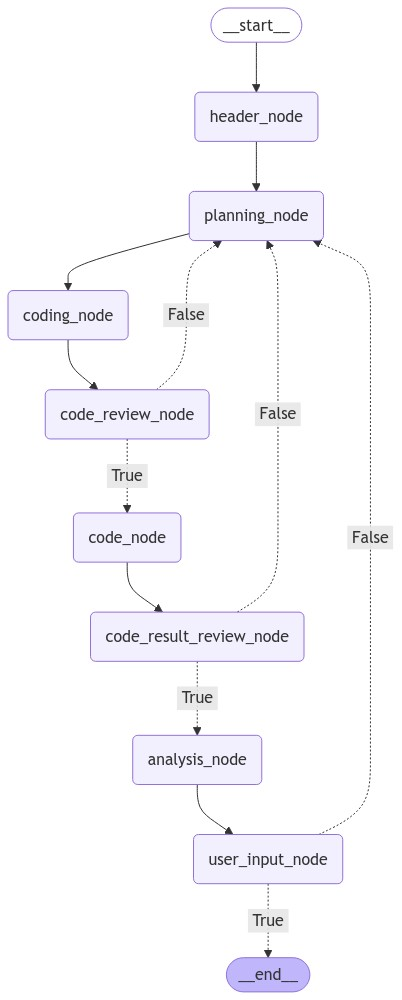

In [22]:
#Visualize graph
compiled_graph = graph.compile()
from IPython.display import Image, display
try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

# Run the pipeline and print output

content="To understand the dataset stored in the file `titanic.csv`, we need to perform a series of steps to explore and analyze the data. Here's a step-by-step plan to achieve this:\n\n1. **Import Necessary Libraries**:\n   - Use the `pandas` library to load and manipulate the dataset.\n\n2. **Load the Dataset**:\n   - Use `pandas.read_csv()` to load the dataset from the file `titanic.csv`.\n\n3. **Inspect the Data**:\n   - Use `head()` to view the first few rows of the dataset to understand its structure.\n   - Use `info()` to get a concise summary of the dataset, including the data types of each column and the presence of any missing values.\n   - Use `describe()` to get statistical summaries of the numerical columns.\n\n4. **Identify Key Columns**:\n   - Determine the key columns that are likely to be present in the Titanic dataset, such as:\n     - `PassengerId`: Unique identifier for each passenger.\n     - `Survived`: Survival status (0 = No, 1 = Yes).\n     - `Pclass`: Passenge

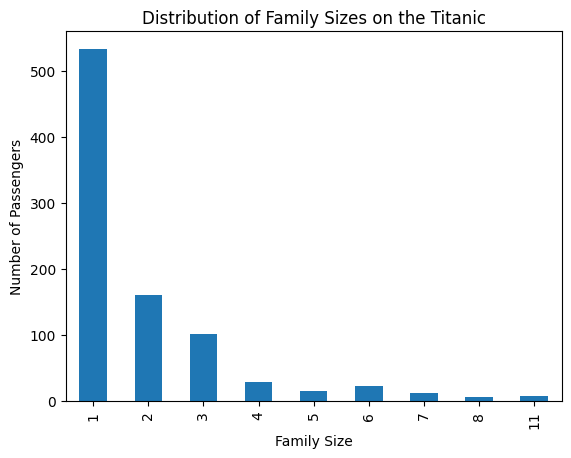

SUCCESS: FamilySize
1     533
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

DECIDING PATH
CORRECT, running code
content='The output provides the distribution of family sizes aboard the Titanic, which is summarized as follows:\n\n- **Family Size of 1**: 533 passengers traveled alone, without any family members.\n- **Family Size of 2**: 161 passengers traveled with one family member.\n- **Family Size of 3**: 102 passengers traveled with two family members.\n- **Family Size of 4**: 29 passengers traveled with three family members.\n- **Family Size of 5**: 15 passengers traveled with four family members.\n- **Family Size of 6**: 22 passengers traveled with five family members.\n- **Family Size of 7**: 12 passengers traveled with six family members.\n- **Family Size of 8**: 6 passengers traveled with seven family members.\n- **Family Size of 11**: 7 passengers traveled with ten family members.\n\nThis distribution indicates that t

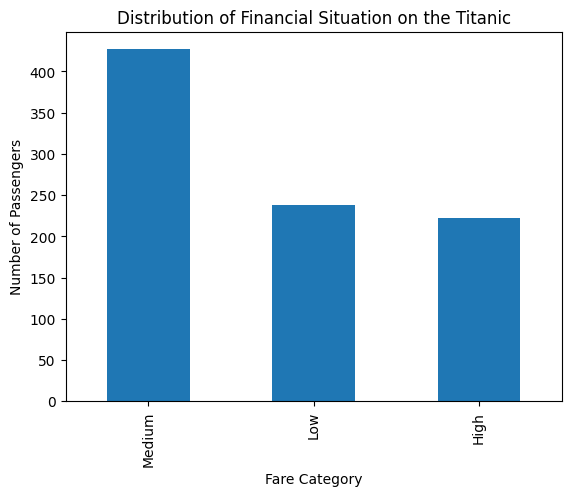

SUCCESS: count    887.00000
mean      32.30542
std       49.78204
min        0.00000
25%        7.92500
50%       14.45420
75%       31.13750
max      512.32920
Name: Fare, dtype: float64
FareCategory
Medium    427
Low       238
High      222
Name: count, dtype: int64

DECIDING PATH
CORRECT, running code
content="The output provides a detailed analysis of the financial situation of passengers on the Titanic based on the `Fare` column. Here's a summary of the findings:\n\n1. **Fare Summary**:\n   - The average fare paid by passengers was approximately 32.31.\n   - The fare ranged from 0 to 512.33.\n   - The 25th percentile fare was 7.93, the median (50th percentile) was 14.45, and the 75th percentile was 31.14.\n\n2. **Fare Categories**:\n   - **Low**: Passengers who paid fares in the lower quartile (up to 7.93) are categorized as having a low financial situation. There are 238 passengers in this category.\n   - **Medium**: Passengers who paid fares between the 25th and 75th percentiles

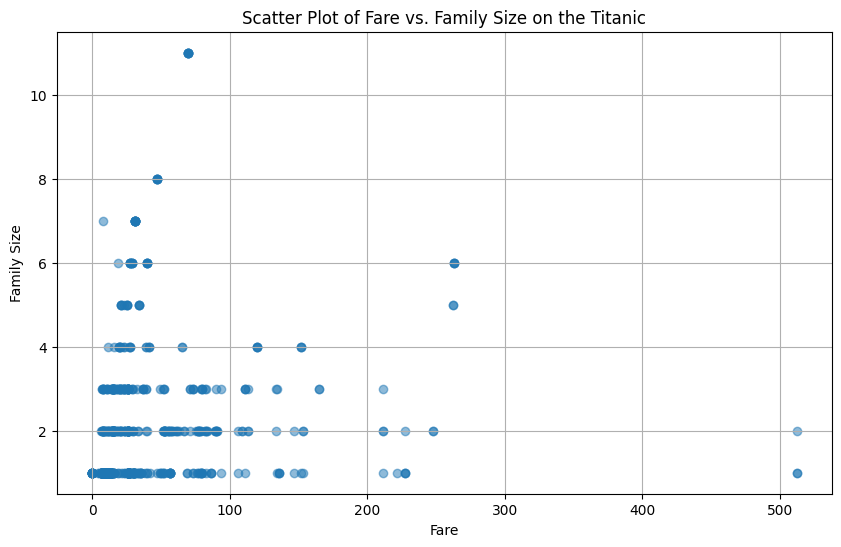

SUCCESS: 
DECIDING PATH
NOT FOUND, not running code
content='Great! The scatter plot was successfully generated, showing the relationship between the fare paid and the family size for each passenger on the Titanic. This visualization can help identify any patterns or trends, such as whether larger families tended to pay more or less for their tickets.\n\nIf you have any more questions or need further analysis, feel free to let me know!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 7356, 'total_tokens': 7426, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a20a4ee344', 'finish_reason': 'stop', 'logprobs': None} id='run-4aeeda7c-df3c-4029-8f27-a129912cf1fe-0' usage_metadata={'input_tokens': 7356, 'output_tokens': 70, 'total_tokens': 7426, 'input_token_details': {'c

GraphRecursionError: Recursion limit of 40 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [28]:
from langchain_core.messages import HumanMessage, AIMessage
import json

events = compiled_graph.stream(
    {
        "messages": [
            HumanMessage(
                content='tell me about the dataset stored in path titanic.csv'
            )
        ],
    },
    {"recursion_limit": 40},
)
for s in events:
    for items in s.values():
      try:
        print(items["messages"][0])
      except:
        pass

